## Calculating Global Coherence as a function of Glacial/Interglacial cycles

This notebook lays out the details of how we use [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to calculate [global coherence](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.global_coherence) between insolation and oxygen isotopes from a subset of records as a function of glacial/interglacial cycles.

The notebook is structured as follows:

1. Define a function that will be used to calculate correlations between records that contain large hiatuses
2. Define insolation curves using [climlab](https://climlab.readthedocs.io/en/latest/)
3. Define boundaries of interglacial/glacial periods use those defined in [LR04](http://www.lorraine-lisiecki.com/LR04_MISboundaries.txt)
4. Break the Sanbao record into glacial/interglacial components and create two series object, one for each.
5. Analyze global coherence between insolation and the glacial/interglacial Sanbao series objects.
6. Repeat steps 4 and 5 for the oxygen isotope data from Buckeye Creek
7. Repeat steps 4 and 5 for oxygen isotope data from a marine sediment core in the Bay of Bengal

In [1]:
# Importing the necessary libraries

import pickle

import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation
from pylipd.lipd import LiPD

In [2]:
# Importing the data

with open("../../data/geo_ms_composite_dict.pkl", "rb") as handle:
    geo_ms_composite_dict = pickle.load(handle)

with open("../../data/cmap_grouped.pkl", "rb") as handle:
    cmap = pickle.load(handle)

with open("../../data/correlated_latitude.pkl", "rb") as handle:
    correlated_latitude = pickle.load(handle)

Creating integrated summer insolation curve at 30N (picked arbitrarily):

In [3]:
# Creating insolation object

# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-1000, 1)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

# Day numbers from June 1st to August 31st
jja_days = np.arange(152, 243)

lat = 30

days = jja_days
inso = daily_insolation(lat=lat, day=days, orb=orb).mean(dim="day")
inso_series = pyleo.Series(
    time=0 - years[::-1],
    value=inso[::-1],
    time_name="Age",
    time_unit="Kyr BP",
    value_name=f"JJA Insolation {lat} N",
    value_unit="W/m^2",
    verbose=False,
)

Building MIS boundaries:

In [4]:
# Building the MIS boundaries

MIS_df = pd.read_table(
    "https://lorraine-lisiecki.com/LR04_MISboundaries.txt",
    skiprows=1,
    header=0,
    delim_whitespace=True,
    nrows=25,
    index_col="Boundary",
)

interglacial_to_glacial = [
    "1/2",
    "5/6",
    "7/8",
    "9/10",
    "11/12",
    "13/14",
    "15/16",
    "17/18",
    "19/20",
]
glacial_to_interglacial = [
    "4/5",
    "6/7",
    "8/9",
    "10/11",
    "12/13",
    "14/15",
    "16/17",
    "18/19",
]

glacial_timing = [
    (
        MIS_df.loc[interglacial_to_glacial[idx]]["Age(ka)"],
        MIS_df.loc[glacial_to_interglacial[idx]]["Age(ka)"],
    )
    for idx in range(len(glacial_to_interglacial))
]
interglacial_timing = [
    (glacial_timing[idx - 1][1], glacial_timing[idx][0])
    for idx in range(1, len(glacial_to_interglacial))
]
interglacial_timing.insert(0, (0, glacial_timing[0][0]))

### Sanbao Analysis

Creating glacial/interglacial series objects using MIS boundaries:

In [5]:
# Creating interglacial series objects

series = geo_ms_composite_dict["Sanbao.China.2016"].convert_time_unit(
    "kyrs BP"
)  # .interp()
value = []
time = []
for interval in interglacial_timing:
    series_interval = series.slice(interval)
    if len(series_interval.time) > 1:
        value.extend(series_interval.value)
        time.extend(series_interval.time)
interglacial_series = series.copy()
interglacial_series.time = time
interglacial_series.value = value

In [6]:
# Creating glacial series objects

value = []
time = []
for interval in glacial_timing:
    series_interval = series.slice(interval)
    if len(series_interval.time) > 1:
        value.extend(series_interval.value)
        time.extend(series_interval.time)
glacial_series = series.copy()
glacial_series.time = time
glacial_series.value = value

Calculating global coherence and plotting:

<Axes: xlabel='Period [kyr]', ylabel='PSD'>

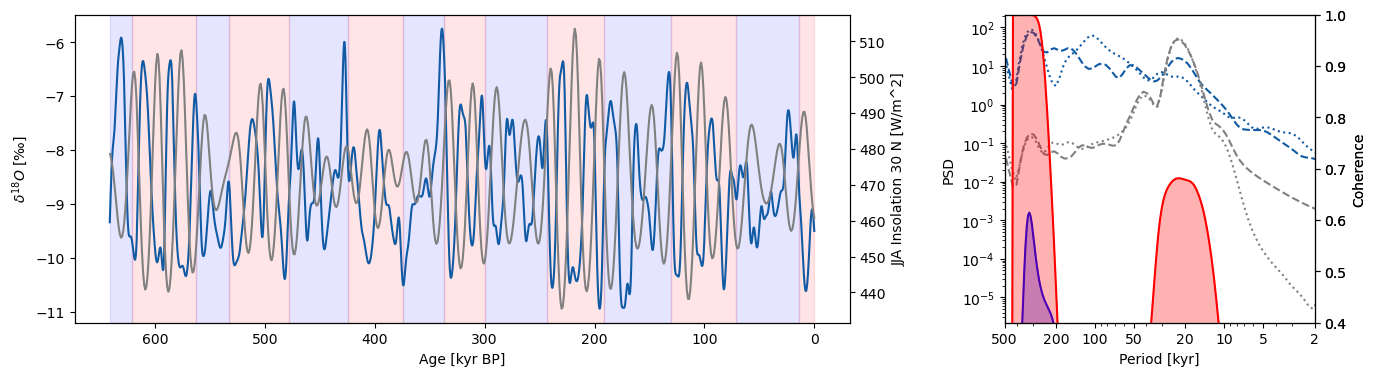

In [7]:
# Calculating coherence and plotting the data

fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(nrows=1, ncols=3, wspace=0.5)
ax = fig.add_subplot(gs[0, 0:2])

ts = geo_ms_composite_dict["Sanbao.China.2016"]

ts.value_name = r"$\delta^{18}O$"
ts.value_unit = "‰"

ts_plot = ts.interp().filter(cutoff_scale=6)

max_age = max(ts.time)
min_age = min(ts.time)

glacial_intervals = []
interglacial_intervals = []

for glacial_end, glacial_start in glacial_timing:
    if min_age < glacial_end < max_age or min_age < glacial_start < max_age:
        glacial_intervals.append(
            [max(min_age, glacial_end), min(max_age, glacial_start)]
        )
for interglacial_end, interglacial_start in interglacial_timing:
    if min_age < interglacial_end < max_age or min_age < interglacial_start < max_age:
        interglacial_intervals.append(
            [max(min_age, interglacial_end), min(max_age, interglacial_start)]
        )

ts_plot.plot(ax=ax, color=cmap[ts.label], legend=False)
ax.invert_xaxis()

for glacial_interval in glacial_intervals:
    ax.axvspan(glacial_interval[0], glacial_interval[1], color="b", alpha=0.1)
for interglacial_interval in interglacial_intervals:
    ax.axvspan(interglacial_interval[0], interglacial_interval[1], color="r", alpha=0.1)

ax_twin = ax.twinx()
ax_twin.grid(False)
inso_series.slice((min(ts.time), max(ts.time))).plot(ax=ax_twin, color="grey")

ax2 = fig.add_subplot(gs[0, 2])

glacial_coh_real = glacial_series.global_coherence(inso_series)
glacial_coh_real.plot(
    ax=ax2,
    spec1_plot_kwargs={"color": cmap[ts.label], "linestyle": "dotted"},
    spec2_plot_kwargs={"color": "grey", "linestyle": "dotted"},
    coh_line_color="blue",
    fill_color="blue",
    legend=False,
)

interglacial_coh_real = interglacial_series.global_coherence(inso_series)
interglacial_coh_real.plot(
    ax=ax2,
    spec1_plot_kwargs={"color": cmap[ts.label], "linestyle": "dashed"},
    spec2_plot_kwargs={"color": "grey", "linestyle": "dashed"},
    coh_line_color="red",
    fill_color="red",
    legend=False,
)

### Buckeye Creek

In [8]:
# Loading smoothed plotting dict, necessary here

with open("../../data/smooth_plotting_series_dict.pkl", "rb") as handle:
    smoothed_plotting_series = pickle.load(handle)

Creating glacial/interglacial series for Buckeye Creek oxygen isotope records:

In [9]:
# Creating the interglacial series

series = geo_ms_composite_dict["BuckeyeCreek.WestVirginia.2019"].convert_time_unit(
    "kyrs BP"
)  # .interp()
value = []
time = []
for interval in interglacial_timing:
    series_interval = series.slice(interval)
    if len(series_interval.time) > 1:
        value.extend(series_interval.value)
        time.extend(series_interval.time)
interglacial_series = series.copy()
interglacial_series.time = time
interglacial_series.value = value

In [10]:
# Creating the glacial series

value = []
time = []
for interval in glacial_timing:
    series_interval = series.slice(interval)
    if len(series_interval.time) > 1:
        value.extend(series_interval.value)
        time.extend(series_interval.time)
glacial_series = series.copy()
glacial_series.time = time
glacial_series.value = value

Calculating global coherence and plotting:

<Axes: xlabel='Period [kyr]', ylabel='PSD'>

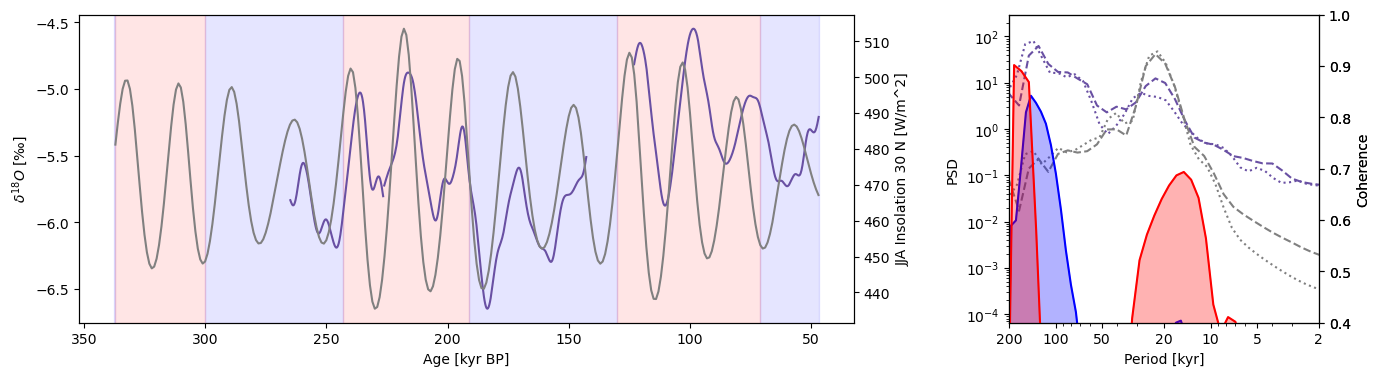

In [11]:
# Calculating coherence and plotting the data

fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(nrows=1, ncols=3, wspace=0.5)
ax = fig.add_subplot(gs[0, 0:2])

ts = geo_ms_composite_dict["BuckeyeCreek.WestVirginia.2019"].convert_time_unit(
    "kyrs BP"
)
ts_plot = smoothed_plotting_series["BuckeyeCreek.WestVirginia.2019"].convert_time_unit(
    "kyrs BP"
)

ts.value_name = r"$\delta^{18}O$"
ts.value_unit = "‰"

max_age = max(ts.time)
min_age = min(ts.time)

glacial_intervals = []
interglacial_intervals = []

for glacial_end, glacial_start in glacial_timing:
    if min_age < glacial_end < max_age or min_age < glacial_start < max_age:
        glacial_intervals.append(
            [max(min_age, glacial_end), min(max_age, glacial_start)]
        )
for interglacial_end, interglacial_start in interglacial_timing:
    if min_age < interglacial_end < max_age or min_age < interglacial_start < max_age:
        interglacial_intervals.append(
            [max(min_age, interglacial_end), min(max_age, interglacial_start)]
        )

ts_plot.plot(ax=ax, color=cmap[ts.label], legend=False)
ax.invert_xaxis()
ax.set_xlabel("Age [kyr BP]")

for glacial_interval in glacial_intervals:
    ax.axvspan(glacial_interval[0], glacial_interval[1], color="b", alpha=0.1)
for interglacial_interval in interglacial_intervals:
    ax.axvspan(interglacial_interval[0], interglacial_interval[1], color="r", alpha=0.1)

ax_twin = ax.twinx()
ax_twin.grid(False)
inso_series.slice((min(ts.time), max(ts.time))).plot(ax=ax_twin, color="grey")

ax2 = fig.add_subplot(gs[0, 2])

glacial_coh_real = glacial_series.global_coherence(inso_series)
glacial_coh_real.plot(
    ax=ax2,
    spec1_plot_kwargs={"color": cmap[ts.label], "linestyle": "dotted"},
    spec2_plot_kwargs={"color": "grey", "linestyle": "dotted"},
    coh_line_color="blue",
    fill_color="blue",
    legend=False,
)

interglacial_coh_real = interglacial_series.global_coherence(inso_series)
interglacial_coh_real.plot(
    ax=ax2,
    spec1_plot_kwargs={"color": cmap[ts.label], "linestyle": "dashed"},
    spec2_plot_kwargs={"color": "grey", "linestyle": "dashed"},
    coh_line_color="red",
    fill_color="red",
    legend=False,
)

### U1446

Loading U1446 from LiPD, as we haven't used this record before:

In [12]:
# Loading the U1446 marine sediment data

lipd_path = "../../data/marine_sediments/U1446.IndianOcean.2021.lpd"

L = LiPD()

if __name__ == "__main__":
    L.load(lipd_path)

Loading 1 LiPD files


  0%|                                                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.80it/s]

Loaded..


Creating a series object from the reconstructed oxygen isotope composition of seawater (we use the TEX86 reconstruction, see the original publication for details):

In [13]:
# Loading the U1446 marine sediment data

ms_dict = {}

for _, row in L.get_timeseries_essentials().iterrows():
    time = row["time_values"]
    time_name = row["time_variableName"]
    time_unit = row["time_units"]
    value = row["paleoData_values"]
    value_name = row["paleoData_variableName"]
    value_unit = row["paleoData_units"]
    lat = row["geo_meanLat"]
    lon = row["geo_meanLon"]
    if value_name == "d18O SW TEX86":
        series = pyleo.GeoSeries(
            time=time,
            value=value,
            time_name=time_name,
            time_unit=time_unit,
            value_name=value_name,
            value_unit=value_unit,
            lat=lat,
            lon=lon,
            archiveType="Marine Sediment",
            verbose=False,
        ).interp()

        sw_series = series.slice([0, 800])
        break

Creating glacial and interglacial series from the U1446 series:

In [14]:
# Creating the interglacial series

series = sw_series
value = []
time = []
for interval in interglacial_timing:
    series_interval = series.slice(interval)
    if len(series_interval.time) > 1:
        value.extend(series_interval.value)
        time.extend(series_interval.time)
interglacial_series = series.copy()
interglacial_series.time = time
interglacial_series.value = value

In [15]:
# Creating the glacial series

value = []
time = []
for interval in glacial_timing:
    series_interval = series.slice(interval)
    if len(series_interval.time) > 1:
        value.extend(series_interval.value)
        time.extend(series_interval.time)
glacial_series = series.copy()
glacial_series.time = time
glacial_series.value = value

Calculating global coherence and plotting:

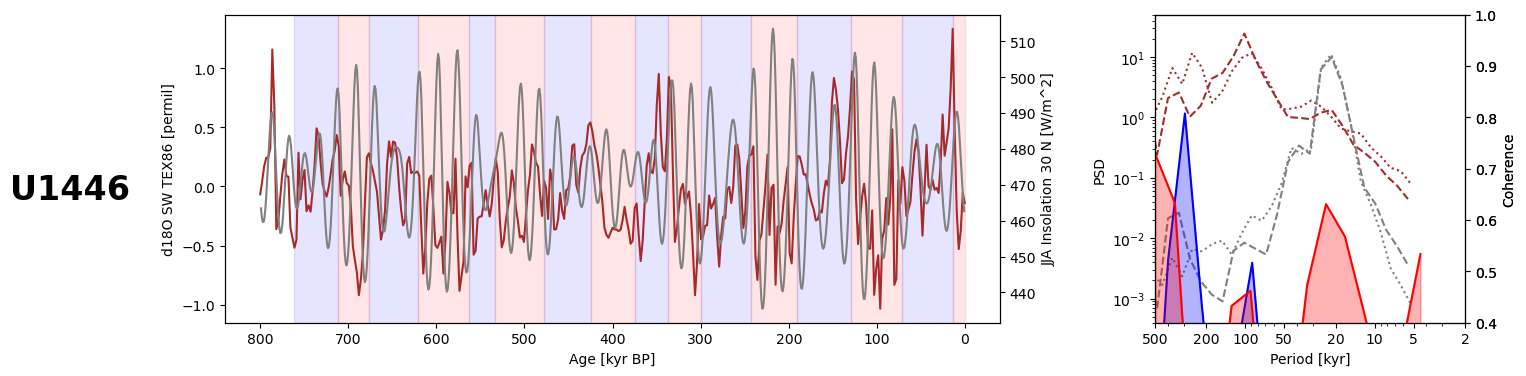

In [16]:
# Calculating coherence and plotting the data

fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(nrows=1, ncols=3, wspace=0.5)
ax = fig.add_subplot(gs[0, 0:2])

ts = series
ts_plot = series.filter(cutoff_scale=5)

ts.value_name = r"$\delta^{18}O$"
ts.value_unit = "‰"

max_age = max(ts.time)
min_age = min(ts.time)

glacial_intervals = []
interglacial_intervals = []

for glacial_end, glacial_start in glacial_timing:
    if min_age < glacial_end < max_age or min_age < glacial_start < max_age:
        glacial_intervals.append(
            [max(min_age, glacial_end), min(max_age, glacial_start)]
        )
for interglacial_end, interglacial_start in interglacial_timing:
    if min_age < interglacial_end < max_age or min_age < interglacial_start < max_age:
        interglacial_intervals.append(
            [max(min_age, interglacial_end), min(max_age, interglacial_start)]
        )

ts_plot.plot(ax=ax, color="brown", legend=False)
ax.invert_xaxis()

for glacial_interval in glacial_intervals:
    ax.axvspan(glacial_interval[0], glacial_interval[1], color="b", alpha=0.1)
for interglacial_interval in interglacial_intervals:
    ax.axvspan(interglacial_interval[0], interglacial_interval[1], color="r", alpha=0.1)

ax_twin = ax.twinx()
ax_twin.grid(False)
inso_series.slice((min(ts.time), max(ts.time))).plot(ax=ax_twin, color="grey")

ax2 = fig.add_subplot(gs[0, 2])

glacial_coh_real = glacial_series.global_coherence(inso_series)
glacial_coh_real.plot(
    ax=ax2,
    spec1_plot_kwargs={"color": "brown", "linestyle": "dotted"},
    spec2_plot_kwargs={"color": "grey", "linestyle": "dotted"},
    coh_line_color="blue",
    fill_color="blue",
    legend=False,
)

interglacial_coh_real = interglacial_series.global_coherence(inso_series)
interglacial_coh_real.plot(
    ax=ax2,
    spec1_plot_kwargs={"color": "brown", "linestyle": "dashed"},
    spec2_plot_kwargs={"color": "grey", "linestyle": "dashed"},
    coh_line_color="red",
    fill_color="red",
    legend=False,
)

ax.text(
    -0.2,
    0.4,
    "U1446",
    transform=ax.transAxes,
    ha="center",
    fontsize=24,
    fontweight="bold",
)
ax2.set_xlim(500, 0)
ax2.set_xticks(
    [500, 200, 100, 50, 20, 10, 5, 2],
)